## Инициализация

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

pd.options.display.max_columns = 100

In [2]:
data = pd.read_csv('train.csv')

## Ищем выбросы с помощью boxplot

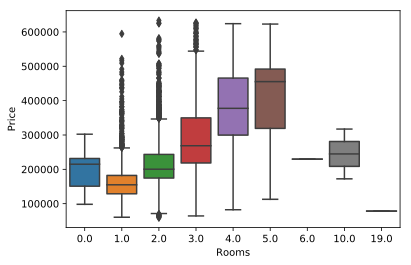

In [3]:
sns.boxplot(data['Rooms'], data['Price'])

Из графика видно, что:
1. есть квартиры с 0 комнат, по ним нужно править кол-во комнат
2. есть квартиры с 6 комнат и более; цена подсказывает, что имеется ошибка в кол-ве комнат
3. для 1-3 комнатных квартир есть выбросы по цене вверх. возможно элитные квартиры.

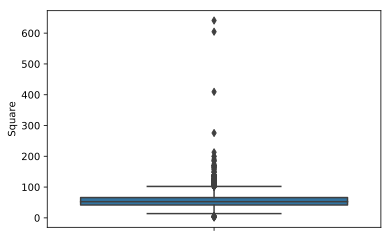

In [4]:
sns.boxplot(data['Square'], orient='v')

Из графика видно, что:
1. Квартиры более 300 кв.м. - выбросы.

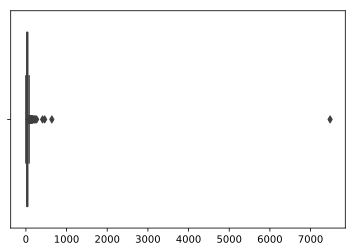

In [5]:
sns.boxplot(data[['LifeSquare']])

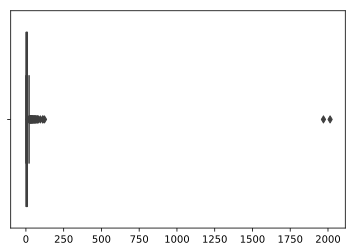

In [6]:
sns.boxplot(data[['KitchenSquare']])

## Первичная очистка

In [7]:
def clean_dataset(df):
    
    # Очистка по слишком маленьким площадям
    df.loc[df['Square'] <= 10, ['Square']] = df.loc[df['Square'] <= 10, ['Square']] * 10
    df.loc[df['Square'] <= 20, ['Square']] = df.loc[df['Square'] <= 20, ['Square']] + 10
    
    # Очистка по слишком большим площадям
    df.loc[df['Square'] >= 300, ['Square']] = df.loc[df['Square'] >= 300, ['Square']] / 10

    # Очистка по комнатам = 0
    # Средний размер 1к = 41, 2к = 57, 3к = 76, 4к = 96, 5к = 118, 6к = 167
    df.loc[(df['Square'] <= np.mean([41, 57]))   & (df['Rooms'] == 0), ['Rooms']] = 1
    df.loc[(df['Square'] <= np.mean([57, 76]))   & (df['Rooms'] == 0), ['Rooms']] = 2
    df.loc[(df['Square'] <= np.mean([76, 96]))   & (df['Rooms'] == 0), ['Rooms']] = 3
    df.loc[(df['Square'] <= np.mean([96, 118]))  & (df['Rooms'] == 0), ['Rooms']] = 4
    df.loc[(df['Square'] <= np.mean([118, 167])) & (df['Rooms'] == 0), ['Rooms']] = 5
    df.loc[(df['Square'] >  np.mean([118, 167])) & (df['Rooms'] == 0), ['Rooms']] = 6
    
    # Очистка ошибок по комнатам >= 6
    df.loc[(df['Square'] <= np.mean([41, 57])) & (df['Rooms'] >= 6), ['Rooms']] = 1
    df.loc[(df['Square'] <= np.mean([57, 76])) & (df['Rooms'] >= 6), ['Rooms']] = 2
    
    # Очистка ошибок по годам постройки
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = df.loc[df['HouseYear'] <= 2020, 'HouseYear'].mean()
    
    # Заполнение пропущенных значений
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df.loc[df['Healthcare_1'].notnull(), 'Healthcare_1'].mean()
    # df.loc[df['LifeSquare'].isnull(),   'LifeSquare']   = df.loc[df['LifeSquare'].isnull(), 'Square'] * 0.85
    
    # Жилая площадь и площадь кухни много где неадекватны
    # df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] = df.loc[df['LifeSquare'] > df['Square'], 'Square'] * 0.85
    df.drop("LifeSquare", axis=1, inplace=True)
    df.drop("KitchenSquare", axis=1, inplace=True)
    
    return df

In [8]:
data = clean_dataset(data)

## Обогащение данных

In [9]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)

In [10]:
mean_price = train.groupby(['DistrictId', 'Rooms'], as_index=False)[['Price']].mean().\
                rename(columns={'Price':'mean_price'})

In [11]:
mean_price_rooms_only = train.groupby(['Rooms'], as_index=False)[['Price']].mean().\
                        rename(columns={'Price':'mean_price_rooms_only'})

In [12]:
six_room_mean_price = mean_price_rooms_only.iloc[mean_price_rooms_only.shape[0]-1, 1] * 1.33

In [13]:
mean_price_rooms_only.append({'Rooms': 6.0, 'mean_price_rooms_only': six_room_mean_price}, ignore_index=True);

In [14]:
def add_mean_price(df, mean_price=mean_price, mean_price_rooms_only=mean_price_rooms_only):
    global six_room_mean_price
    df = pd.merge(df, mean_price_rooms_only, on='Rooms', how='left')
    df['mean_price_rooms_only'] = df['mean_price_rooms_only'].fillna(six_room_mean_price)
    df = pd.merge(df, mean_price, on=['DistrictId','Rooms'], how='left')
    df['mean_price'] = df['mean_price'].fillna(df['mean_price_rooms_only'])
    df = df.drop('mean_price_rooms_only', axis=1)
    # Категориальные признаки превратим в числовые:
    df = pd.get_dummies(df)
    return df

In [15]:
train = add_mean_price(train)

In [16]:
valid = add_mean_price(valid)

## Загрузка модулей

In [17]:
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Lasso, Ridge

#from sklearn.svm import SVR

#from sklearn.neighbors import KNeighborsRegressor as KNR

#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score as r2

In [18]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler

## Построение моделей

Случайный лес

In [19]:
all_feats = train.columns.drop(['Price', 'Id'])

In [20]:
#parameters = {
#    'n_estimators': [150, 200, 250, 300],
#    'max_features': np.arange(3, 20),
#    'max_depth': np.arange(5, 25),
#}
#
#clf = GridSearchCV(
#    estimator=RFR(),
#    param_grid=parameters,
#    scoring='r2',
#    cv=5,
#    n_jobs=-1
#)

In [21]:
# clf.fit(train.loc[:, all_feats], train['Price'])

In [22]:
# clf.best_params_

In [23]:
model = RFR(max_depth=50, max_features=4, n_estimators=1000, n_jobs=-1)

model.fit(train.loc[:, all_feats], train['Price'])

y_pred = model.predict(valid.loc[:, all_feats])

r2(valid['Price'], y_pred)

0.7149524598331181

## TEST

In [24]:
test = pd.read_csv('test.csv')

In [25]:
test = clean_dataset(test)

In [26]:
test = add_mean_price(test)

In [27]:
test['Price'] = model.predict(test.loc[:, all_feats])

In [28]:
test.head()

,Id,DistrictId,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,mean_price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
0,725,58,2.0,49.882643,6,14.0,1972.0,0.310199,11,2748,1,1146.657263,0,0,170278.368262,0,1,0,1,0,1,158256.394761
1,15856,74,2.0,69.263183,6,1.0,1977.0,0.075779,6,1437,3,1146.657263,0,2,240692.688382,0,1,0,1,0,1,241990.339485
2,5480,190,1.0,23.597819,2,5.0,1909.0,0.000000,30,7538,87,4702.000000,5,5,160066.534853,0,1,0,1,0,1,177607.238027
3,15664,47,2.0,73.046609,22,22.0,2007.0,0.101872,23,4583,3,1146.657263,3,3,198197.383850,0,1,0,1,0,1,266540.887635
4,14275,27,1.0,47.527111,17,17.0,2017.0,0.072158,2,629,1,1146.657263,0,0,123468.815347,0,1,0,1,1,0,144165.204849


In [29]:
test.loc[:, ['Id', 'Price']].to_csv('DUrvantsev_predictions.csv', index=None)